# Developing custom gradient and multiple shooting method for full ephemeris transition

In [156]:
import numpy as np
import spiceypy as spice
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import pygmo as pg
import pygmo_plugins_nonfree as ppnf
from pprint import pprint

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
import sys 
sys.path.append("../")
import luna2

In [297]:
def print_matrix(mat, max_digit=7):
    nrow,ncol = mat.shape
    for i in range(nrow):
        row_str = ""
        for j in range(ncol):
            num_str = f"{mat[i,j]: 1.2f}"
            row_str += " "*(max_digit - len(num_str)) + num_str + " "
        print(row_str)
    return

In [3]:
spice.furnsh(os.path.join(os.getenv("SPICE"), "lsk", "naif0012.tls"))
spice.furnsh(os.path.join(os.getenv("SPICE"), "spk", "de440.bsp"))
spice.furnsh(os.path.join("..", "assets", "spice", "earth_moon_rotating_mc.tf"))  # custom frame kernel

In [30]:
# seed halo in CR3BP
mu_cr3bp = 1.215058560962404E-2
lstar = 389703.0
tstar = 382981.0
vstar = lstar/tstar

# ID723 in southern halo
x0_cr3bp = np.array([
    1.0134037728554581E+0, 0, -1.7536227281091840E-1,
    0, -8.3688427472776439E-2, 0
])
period = 1.3960732332950263E+0

In [31]:
# create CR3BP propagator & propagate over one period
prop_cr3bp = luna2.PropagatorCR3BP(mu_cr3bp)
#t_eval = np.linspace(0,period,500)   
t_eval = [0, period/2, period, 1.5*period, 2*period]
res_cr3bp = prop_cr3bp.solve(
    [0,t_eval[-1]], x0_cr3bp, t_eval=t_eval, dense_output=True
)
states_cr3bp_MC = luna2.canonical_to_dimensional(
    luna2.shift_barycenter_to_m2(res_cr3bp.y, mu_cr3bp),
    lstar, 
    vstar
)

In [224]:
# transform to propagator's frame
et0 = spice.utc2et("2025-12-18T12:28:28")
epochs = et0 + res_cr3bp.t*tstar
states_J2000 = luna2.apply_frame_transformation(
    epochs,
    states_cr3bp_MC,
    "EARTHMOONROTATINGMC",
    "J2000"
)
states_J2000 = luna2.dimensional_to_canonical(states_J2000, lstar, vstar)

# create N-body propagator
print("Creating N-body integrator...")
et0 = spice.utc2et("2025-12-18T12:28:28")
mus = [
    mu_cr3bp,    #4902.800066,
    1-mu_cr3bp,  #398600.44,
]
prop_nbody = luna2.PropagatorNBody(
    "J2000",
    ["301", "399"], 
    mus,
    lstar,
    tstar,
    use_canonical=True,
)
res_nbody = prop_nbody.solve(
    et0,
    [0,res_cr3bp.t[-1]],
    states_J2000[:,0],
    t_eval=np.linspace(0,res_cr3bp.t[-1],1000)
)

Creating N-body integrator...


In [225]:
# Construct nodes for two revolutions
state_half_period = states_J2000[:,1]
nodes = [
    states_J2000[:,0],
    states_J2000[:,1],
    #states_J2000[:,2],
    #states_J2000[:,3],
    #states_J2000[:,4],
]
tofs = [period/2 + idx for idx in range(len(nodes)-1)]
tofs_bounds = [
    [tof*0.85, tof*1.15] for tof in tofs
]

# create bounds on et0 and nodes
et0_bounds = [et0 - 1000, et0 + 1000]
nodes_bounds = [
    luna2.get_node_bounds_relative(states_J2000[:,0], [0.15, 0.05, 0.15, 0.05, 0.15, 0.05]),
    luna2.get_node_bounds_relative(states_J2000[:,1], [0.15, 0.05, 0.15, 0.05, 0.15, 0.05]),
    #luna2.get_node_bounds_relative(states_J2000[:,2], [0.15, 0.05, 0.15, 0.05, 0.15, 0.05]),
    #luna2.get_node_bounds_relative(states_J2000[:,3], [0.15, 0.05, 0.15, 0.05, 0.15, 0.05]),
    #luna2.get_node_bounds_relative(states_J2000[:,4], [0.15, 0.05, 0.15, 0.05, 0.15, 0.05]),
]

# create UDP for full-ephemeris transition
udp = luna2.FullEphemerisTransition(
    prop_nbody,
    et0,
    nodes,
    tofs,
    et0_bounds=et0_bounds,
    nodes_bounds=nodes_bounds,
    tofs_bounds=tofs_bounds,
)
lb,ub = udp.get_bounds()

In [220]:
et0

819332977.1835357

In [193]:
# build nominal decision vector to test routines
xtest = (np.array(ub) + np.array(lb))/2
fvec, sol_fwd_list, sol_bck_list = udp.fitness(xtest, True, True)

# unpack decision vector
et_nodes, tofs, nodes = udp.unpack_x(xtest)

Appending inequality 0: [-0.00037950967541730204, 0.0002845200024350972, 0.0008140964614195556, 0.0026439150607025785, -0.006656622068177728, 0.006405466725591141]


In [275]:
svf0, stm0, sol0 = prop_nbody.get_stm_cdm(et_nodes[0], tofs[0]/2, nodes[0], get_svf=True)
svdot0 = prop_nbody.eom(et_nodes[0], 0, svf0)
print_matrix(-stm0)

    -0.824     -0.015     -0.049     -0.327     -0.001     -0.007 
    -0.016     -0.947      0.083     -0.001     -0.342      0.011 
    -0.048      0.083     -1.249     -0.007      0.011     -0.379 
     1.059     -0.017     -0.353     -0.792      0.006     -0.071 
    -0.026      0.326      0.584      0.005     -0.935      0.113 
    -0.333      0.570     -1.649     -0.069      0.112     -1.298 


In [276]:
print_matrix(grad.reshape(7,14)[1:,1:][0:6,0:6])

    -0.824     -0.015     -0.049     -0.327     -0.001     -0.007 
    -0.016     -0.947      0.083     -0.001     -0.342      0.011 
    -0.048      0.083     -1.249     -0.007      0.011     -0.379 
     1.059     -0.017     -0.353     -0.792      0.006     -0.071 
    -0.026      0.326      0.584      0.005     -0.935      0.113 
    -0.333      0.570     -1.649     -0.069      0.112     -1.298 


In [277]:
svf1, stm1, sol1 = prop_nbody.get_stm_cdm(et_nodes[1], -tofs[0]/2, nodes[1], get_svf=True)
svdot1 = prop_nbody.eom(et_nodes[1], 0, svf1)
print_matrix(stm1)

    32.961    105.493   -186.468     -0.994     -0.301     -0.043 
    14.184    -40.056     35.214      0.234      0.026      0.075 
    14.091    104.215   -246.295     -1.248     -0.319     -0.215 
   -58.156   -264.766    505.830      2.685      0.758      0.278 
    -7.612    178.469   -282.813     -1.532     -0.372     -0.299 
   -72.261   -508.513   1115.086      5.707      1.466      0.891 


In [278]:
print_matrix(grad.reshape(7,14)[1:,1:][0:6,6:12])

    32.961    105.493   -186.468     -0.994     -0.301     -0.043 
    14.184    -40.056     35.214      0.234      0.026      0.075 
    14.091    104.215   -246.295     -1.248     -0.319     -0.215 
   -58.156   -264.766    505.830      2.685      0.758      0.278 
    -7.612    178.469   -282.813     -1.532     -0.372     -0.299 
   -72.261   -508.513   1115.086      5.707      1.466      0.891 


In [295]:
print_matrix(B, 7)

  0.824   0.015   0.049   0.327   0.001   0.007  32.961  105.493 -186.468  -0.994  -0.301  -0.043 
  0.016   0.947  -0.083   0.001   0.342  -0.011  14.184 -40.056  35.214   0.234   0.026   0.075 
  0.048  -0.083   1.249   0.007  -0.011   0.379  14.091  104.215 -246.295  -1.248  -0.319  -0.215 
 -1.059   0.017   0.353   0.792  -0.006   0.071 -58.156 -264.766  505.830   2.685   0.758   0.278 
  0.026  -0.326  -0.584  -0.005   0.935  -0.113  -7.612  178.469 -282.813  -1.532  -0.372  -0.299 
  0.333  -0.570   1.649   0.069  -0.112   1.298 -72.261 -508.513  1115.086   5.707   1.466   0.891 


In [307]:
B = np.concatenate((-stm0,stm1), axis=1)
C = svdot1*(-1/2) - svdot0*(1/2)

In [310]:
print_matrix(np.concatenate((B,C.reshape(-1,1)), axis=1), max_digit=7)

  -0.82   -0.01   -0.05   -0.33   -0.00   -0.01   32.96  105.49 -186.47   -0.99   -0.30   -0.04    0.04 
  -0.02   -0.95    0.08   -0.00   -0.34    0.01   14.18  -40.06   35.21    0.23    0.03    0.08    0.08 
  -0.05    0.08   -1.25   -0.01    0.01   -0.38   14.09  104.22 -246.30   -1.25   -0.32   -0.21   -0.18 
   1.06   -0.02   -0.35   -0.79    0.01   -0.07  -58.16 -264.77  505.83    2.69    0.76    0.28   -0.10 
  -0.03    0.33    0.58    0.00   -0.93    0.11   -7.61  178.47 -282.81   -1.53   -0.37   -0.30    0.30 
  -0.33    0.57   -1.65   -0.07    0.11   -1.30  -72.26 -508.51  1115.09    5.71    1.47    0.89   -0.61 


In [311]:
print_matrix(grad.reshape(7,14), max_digit=7)

   0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00 
  -0.00   -0.82   -0.01   -0.05   -0.33   -0.00   -0.01   32.96  105.49 -186.47   -0.99   -0.30   -0.04    0.04 
   0.00   -0.02   -0.95    0.08   -0.00   -0.34    0.01   14.18  -40.06   35.21    0.23    0.03    0.08    0.09 
   0.00   -0.05    0.08   -1.25   -0.01    0.01   -0.38   14.09  104.22 -246.30   -1.25   -0.32   -0.21   -0.18 
  -0.00    1.06   -0.02   -0.35   -0.79    0.01   -0.07  -58.16 -264.77  505.83    2.69    0.76    0.28   -0.12 
  -0.00   -0.03    0.33    0.58    0.00   -0.93    0.11   -7.61  178.47 -282.81   -1.53   -0.37   -0.30    0.29 
  -0.00   -0.33    0.57   -1.65   -0.07    0.11   -1.30  -72.26 -508.51  1115.09    5.71    1.47    0.89   -0.62 


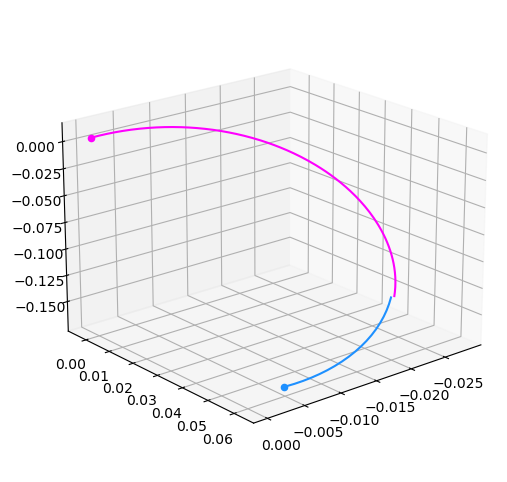

In [192]:
fig = plt.figure(figsize = (6, 6))
ax = plt.axes(projection = '3d')

# ax.scatter(sol0.y[0,0], sol0.y[1,0], sol0.y[2,0], marker="o", color="dodgerblue")
# ax.plot(sol0.y[0,:], sol0.y[1,:], sol0.y[2,:], color="dodgerblue")

# ax.scatter(sol1.y[0,0], sol1.y[1,0], sol1.y[2,0], marker="o", color="magenta")
# ax.plot(sol1.y[0,:], sol1.y[1,:], sol1.y[2,:], color="magenta")

for sol0 in sol_fwd_list:
    ax.scatter(sol0.y[0,0], sol0.y[1,0], sol0.y[2,0], marker="o", color="dodgerblue")
    ax.plot(sol0.y[0,:], sol0.y[1,:], sol0.y[2,:], color="dodgerblue")

for sol1 in sol_bck_list:
    ax.scatter(sol1.y[0,0], sol1.y[1,0], sol1.y[2,0], marker="o", color="magenta")
    ax.plot(sol1.y[0,:], sol1.y[1,:], sol1.y[2,:], color="magenta")

ax.view_init(20,50)
plt.show()

In [226]:
# test gradient evaluation
grad = udp.gradient(xtest, dx=1e-6, use_h=False)

In [161]:
#print_matrix(grad.reshape(7,14), max_digit=7)

In [298]:
print_matrix(grad.reshape(7,14)[1:,1:], max_digit=7)

  -0.82   -0.01   -0.05   -0.33   -0.00   -0.01   32.96  105.49 -186.47   -0.99   -0.30   -0.04    0.04 
  -0.02   -0.95    0.08   -0.00   -0.34    0.01   14.18  -40.06   35.21    0.23    0.03    0.08    0.09 
  -0.05    0.08   -1.25   -0.01    0.01   -0.38   14.09  104.22 -246.30   -1.25   -0.32   -0.21   -0.18 
   1.06   -0.02   -0.35   -0.79    0.01   -0.07  -58.16 -264.77  505.83    2.69    0.76    0.28   -0.12 
  -0.03    0.33    0.58    0.00   -0.93    0.11   -7.61  178.47 -282.81   -1.53   -0.37   -0.30    0.29 
  -0.33    0.57   -1.65   -0.07    0.11   -1.30  -72.26 -508.51  1115.09    5.71    1.47    0.89   -0.62 


In [299]:
print_matrix(grad.reshape(7,14)[1:,1:][0:6,0:6], max_digit=7)

  -0.82   -0.01   -0.05   -0.33   -0.00   -0.01 
  -0.02   -0.95    0.08   -0.00   -0.34    0.01 
  -0.05    0.08   -1.25   -0.01    0.01   -0.38 
   1.06   -0.02   -0.35   -0.79    0.01   -0.07 
  -0.03    0.33    0.58    0.00   -0.93    0.11 
  -0.33    0.57   -1.65   -0.07    0.11   -1.30 
